In [40]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray

from utils.given import get_harris_corners, dist_SSD
from utils.others import nms_local_max, discard_edges, extract_descriptors, save_current_plot
from utils.panaroma import estimate_homography_ransac, make_panorama_canvas, blend_average, crop_nonzero

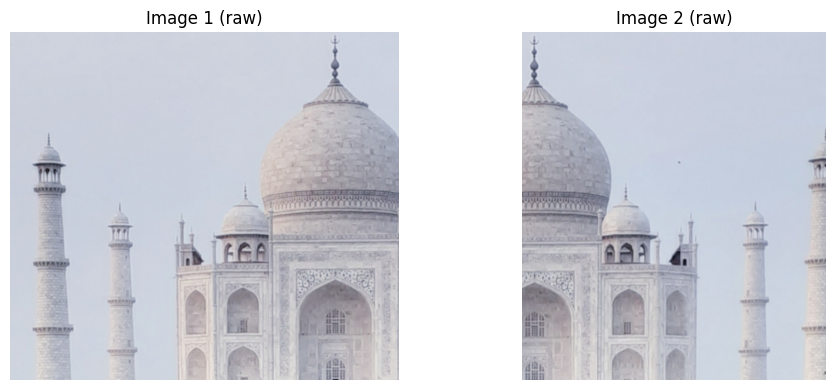

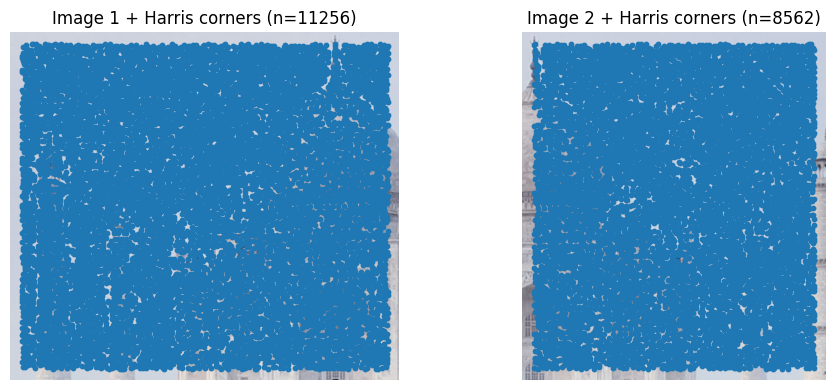

In [ ]:
# *********************************************
# Step 1: Harris Corner Detection
# *********************************************

filename="taj_mahal"
# filename="hill"

# 1) Load images
img1 = imread("data/img1.jpg")
img2 = imread("data/img2.jpg")

# Keep originals for display
img1_show = img1
img2_show = img2

# 2) Convert to grayscale for Harris
im1 = rgb2gray(img1) if img1.ndim == 3 else img1
im2 = rgb2gray(img2) if img2.ndim == 3 else img2

# 3) Harris corners
h1, coords1 = get_harris_corners(im1, edge_discard=20)  # coords1: 2 x N (ys, xs)
h2, coords2 = get_harris_corners(im2, edge_discard=20)  # coords2: 2 x N (ys, xs)

# --------------------------
# Deliverable 1: raw images
# --------------------------
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img1_show, cmap='gray' if img1_show.ndim == 2 else None)
plt.title("Image 1 (raw)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img2_show, cmap='gray' if img2_show.ndim == 2 else None)
plt.title("Image 2 (raw)")
plt.axis("off")

plt.tight_layout()
save_current_plot(f"1_{filename}_raw.png")
plt.show()

# ---------------------------------------------
# Deliverable 2: images with corners overlaid
# ---------------------------------------------
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img1_show, cmap='gray' if img1_show.ndim == 2 else None)
plt.scatter(coords1[1], coords1[0], s=10, marker='o')  # x=xs, y=ys
plt.title(f"Image 1 + Harris corners (n={coords1.shape[1]})")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img2_show, cmap='gray' if img2_show.ndim == 2 else None)
plt.scatter(coords2[1], coords2[0], s=10, marker='o')
plt.title(f"Image 2 + Harris corners (n={coords2.shape[1]})")
plt.axis("off")

plt.tight_layout()
save_current_plot(f"2_{filename}_harris_corners.png")
plt.show()

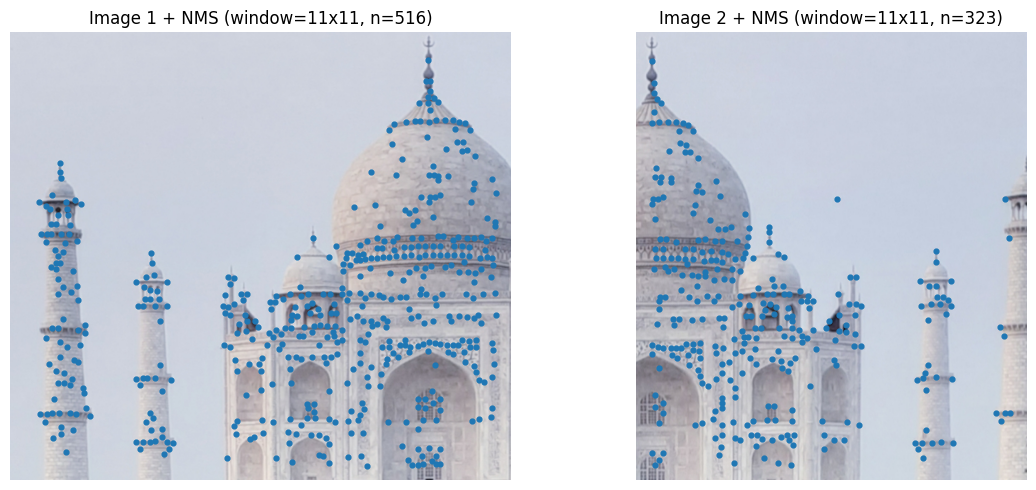

In [42]:
# *********************************************
# Step 2: Non-Maximal Suppression (NMS)
# *********************************************

# window size
W = 11
coords1_nms = nms_local_max(h1, window_size=W, threshold_rel=0.01)
coords2_nms = nms_local_max(h2, window_size=W, threshold_rel=0.01)

# discard corners within this distance from image edges
edge = 20
coords1_nms = discard_edges(coords1_nms, im1.shape[0], im1.shape[1], edge=edge)
coords2_nms = discard_edges(coords2_nms, im2.shape[0], im2.shape[1], edge=edge)

# ---------------------------------------------
# Deliverable 3: show chosen corners overlaid side-by-side
# ---------------------------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(img1, cmap="gray" if img1.ndim == 2 else None)
plt.scatter(coords1_nms[1], coords1_nms[0], s=12, marker='o')
plt.title(f"Image 1 + NMS (window={W}x{W}, n={coords1_nms.shape[1]})")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img2, cmap="gray" if img2.ndim == 2 else None)
plt.scatter(coords2_nms[1], coords2_nms[0], s=12, marker='o')
plt.title(f"Image 2 + NMS (window={W}x{W}, n={coords2_nms.shape[1]})")
plt.axis("off")

plt.tight_layout()
save_current_plot(f"3_{filename}_harris_corners_nms.png")
plt.show()

In [43]:
# *********************************************
# Step 3: Feature Descriptor Extraction
# *********************************************

img1 = imread("data/img1.jpg")
img2 = imread("data/img2.jpg")

img1 = img1[:, :, :3] if img1.ndim == 3 else img1
img2 = img2[:, :, :3] if img2.ndim == 3 else img2

desc1 = extract_descriptors(img1, coords1_nms, patch_size=40, out_size=8)
print("desc1 shape:", desc1.shape)  # (N1, 64)

desc2 = extract_descriptors(img2, coords2_nms, patch_size=40, out_size=8)
print("desc2 shape:", desc2.shape)  # (N2, 64)

desc1 shape: (516, 192)
desc2 shape: (323, 192)


Image1 features: 516
Image2 features: 323
Good matches: 119
NNDR threshold: 0.5


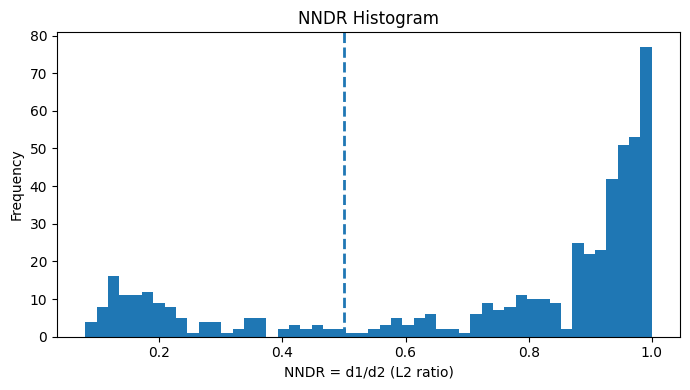

In [44]:
# *********************************************
# Step 4: Feature Matching
# *********************************************

# 1) Pairwise descriptor distances (squared L2)
D = dist_SSD(desc1, desc2) 

# 2) Find 1st and 2nd nearest neighbors in image2 for each descriptor in image1
nn_sorted = np.argsort(D, axis=1)   # indices of img2 descriptors sorted by distance
nn1 = nn_sorted[:, 0]              # best match index in img2 (N1,)
nn2 = nn_sorted[:, 1]              # second-best match index in img2 (N1,)

# best and second best squared distances
d1 = D[np.arange(D.shape[0]), nn1]
d2 = D[np.arange(D.shape[0]), nn2] 

# 3) NNDR ratio
nndr = np.sqrt(d1 / (d2 + 1e-12))

# 4) choose threshold
THRESH = 0.5

good = nndr < THRESH
matches = np.vstack([np.where(good)[0], nn1[good]]).T

print("Image1 features:", desc1.shape[0])
print("Image2 features:", desc2.shape[0])
print("Good matches:", matches.shape[0])
print("NNDR threshold:", THRESH)

# ---------------------------------------------
# Deliverable 4: NNDR histogram + threshold line
# ---------------------------------------------
plt.figure(figsize=(7, 4))
plt.hist(nndr, bins=50)
plt.axvline(THRESH, linestyle="--", linewidth=2)
plt.title("NNDR Histogram")
plt.xlabel("NNDR = d1/d2 (L2 ratio)")
plt.ylabel("Frequency")
plt.tight_layout()
save_current_plot(f"4_{filename}_nndr_histogram.png")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1805422..2.0864913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1757543..2.050332].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6186907..2.0063665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3526918..2.7427135].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2565458..2.64956].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1250982..2.8464599].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6193151..

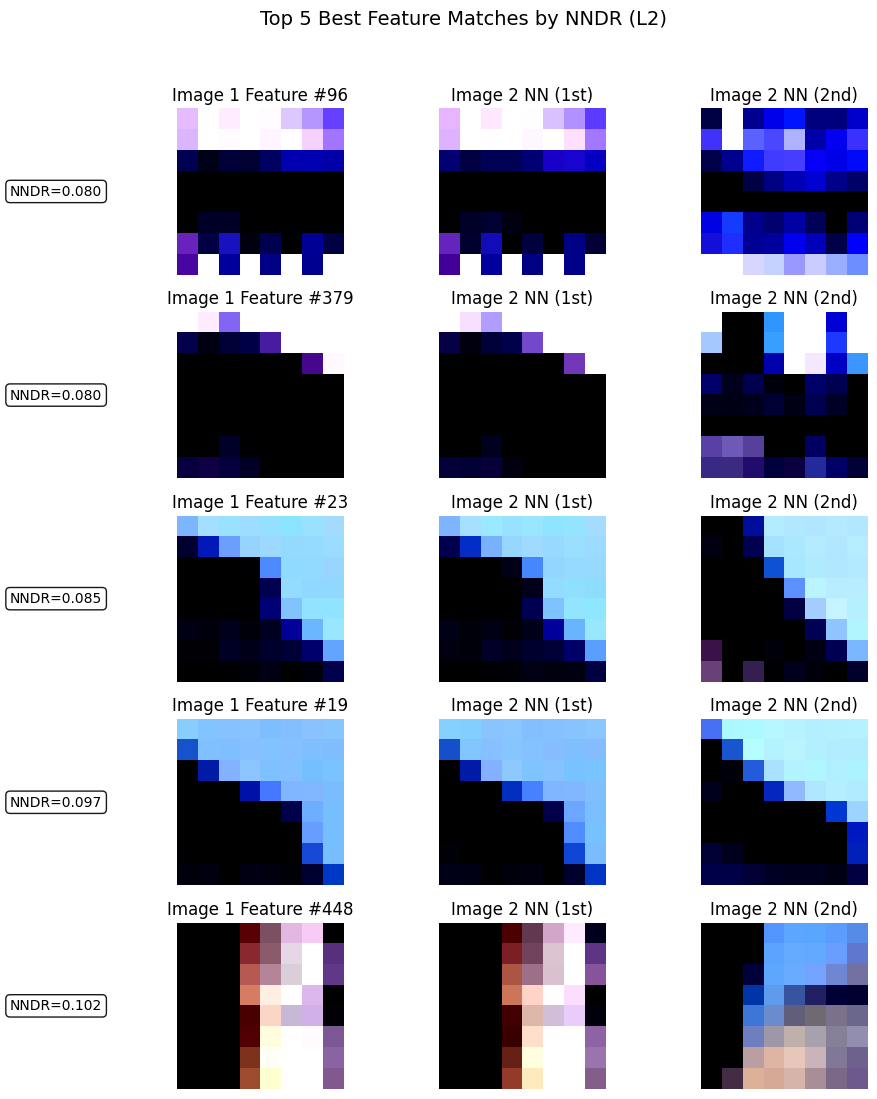

In [45]:
# ---------------------------------------------
# Deliverable 5: Top 5 features by smallest NNDR
# ---------------------------------------------
K = 5  

best_ids = np.argsort(nndr)[:5]

plt.figure(figsize=(10, 2*K + 1))
plt.suptitle("Top 5 Best Feature Matches by NNDR (L2)", y=0.995, fontsize=14)

for r, idx1 in enumerate(best_ids):
    j1 = nn1[idx1]  # img2 nearest neighbor
    j2 = nn2[idx1]  # img2 second nearest neighbor

    patch1 = desc1[idx1].reshape(8, 8, 3)
    patch2 = desc2[j1].reshape(8, 8, 3)
    patch3 = desc2[j2].reshape(8, 8, 3)

    # Column 1: Image1 feature
    ax = plt.subplot(K, 3, r*3 + 1)
    ax.imshow(patch1, cmap="gray", interpolation="nearest")
    ax.set_title(f"Image 1 Feature #{idx1+1}")
    ax.axis("off")
    ax.text(-0.45, 0.5, f"NNDR={nndr[idx1]:.3f}", transform=ax.transAxes,
            va="center", ha="right",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))

    # Column 2: Image2 nearest neighbor
    ax = plt.subplot(K, 3, r*3 + 2)
    ax.imshow(patch2, cmap="gray", interpolation="nearest")
    ax.set_title("Image 2 NN (1st)")
    ax.axis("off")

    # Column 3: Image2 second nearest neighbor
    ax = plt.subplot(K, 3, r*3 + 3)
    ax.imshow(patch3, cmap="gray", interpolation="nearest")
    ax.set_title("Image 2 NN (2nd)")
    ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.97])
save_current_plot(f"5_{filename}_best_features_by_nndr.png")
plt.show()

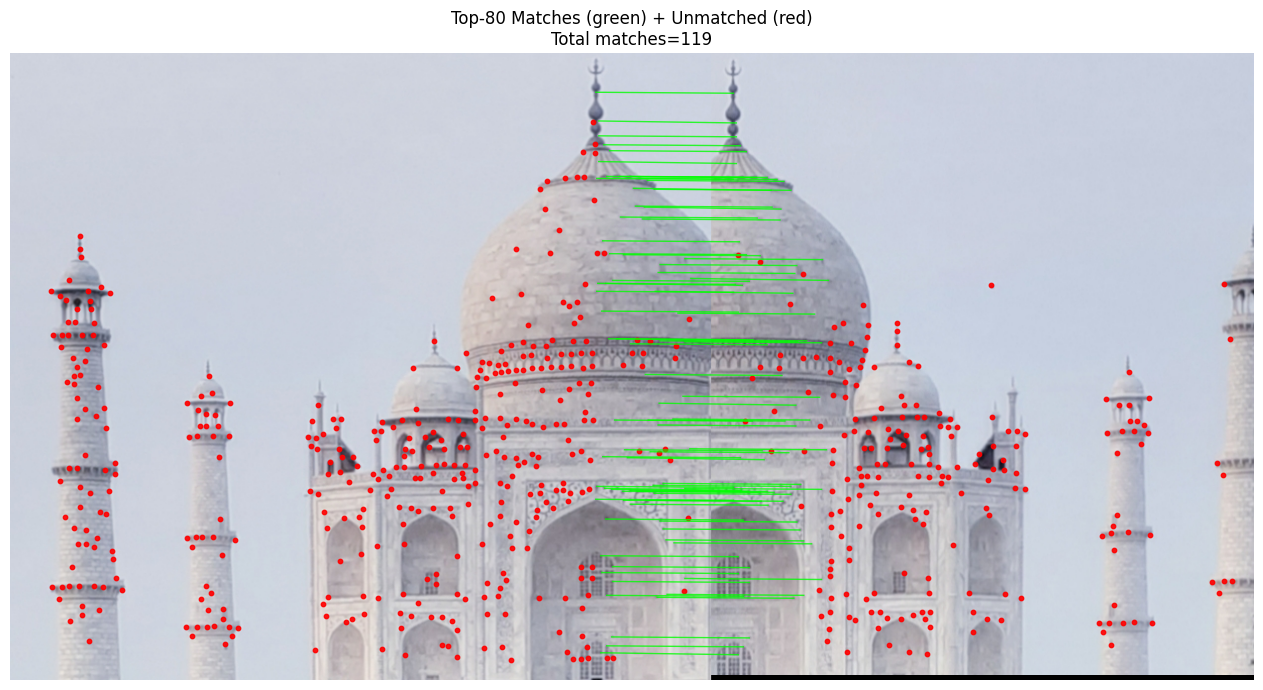

In [46]:
# *********************************************
# Step 5: Visualize Matches - by LLM
# *********************************************
TOP_N = 80

# matches is Kx2: [idx1, idx2]
# nndr is length N1. Get NNDR for each kept match:
match_scores = nndr[matches[:, 0]]

# sort matches by NNDR (best = smallest)
order = np.argsort(match_scores)
matches_sorted = matches[order]

# keep only top N
matches_draw = matches_sorted[:min(TOP_N, matches_sorted.shape[0])]

# canvas
H1, W1 = img1.shape[0], img1.shape[1]
H2, W2 = img2.shape[0], img2.shape[1]
H = max(H1, H2)
W = W1 + W2

canvas = np.zeros((H, W, 3), dtype=img1.dtype)
canvas[:H1, :W1, :] = img1[:, :, :3]
canvas[:H2, W1:W1+W2, :] = img2[:, :, :3]

# matched/unmatched sets (still based on ALL matches, not just drawn ones)
N1 = coords1_nms.shape[1]
N2 = coords2_nms.shape[1]
matched_idx1 = set(matches[:, 0].tolist())
matched_idx2 = set(matches[:, 1].tolist())
unmatched_idx1 = np.array(sorted(list(set(range(N1)) - matched_idx1)), dtype=int)
unmatched_idx2 = np.array(sorted(list(set(range(N2)) - matched_idx2)), dtype=int)

plt.figure(figsize=(14, 7))
plt.imshow(canvas)
plt.axis("off")
plt.title(f"Top-{matches_draw.shape[0]} Matches (green) + Unmatched (red)\nTotal matches={matches.shape[0]}")

# draw green lines (only top-N)
for i1, i2 in matches_draw:
    y1, x1 = coords1_nms[0, i1], coords1_nms[1, i1]
    y2, x2 = coords2_nms[0, i2], coords2_nms[1, i2]
    plt.plot([x1, x2 + W1], [y1, y2], color="lime", linewidth=1, alpha=0.8)

# red dots for unmatched
if unmatched_idx1.size > 0:
    plt.scatter(coords1_nms[1, unmatched_idx1], coords1_nms[0, unmatched_idx1],
                s=10, c="red", alpha=0.9)

if unmatched_idx2.size > 0:
    plt.scatter(coords2_nms[1, unmatched_idx2] + W1, coords2_nms[0, unmatched_idx2],
                s=10, c="red", alpha=0.9)

plt.tight_layout()
save_current_plot(f"6_{filename}_matches.png")
plt.show()

Inliers: 111 / 119


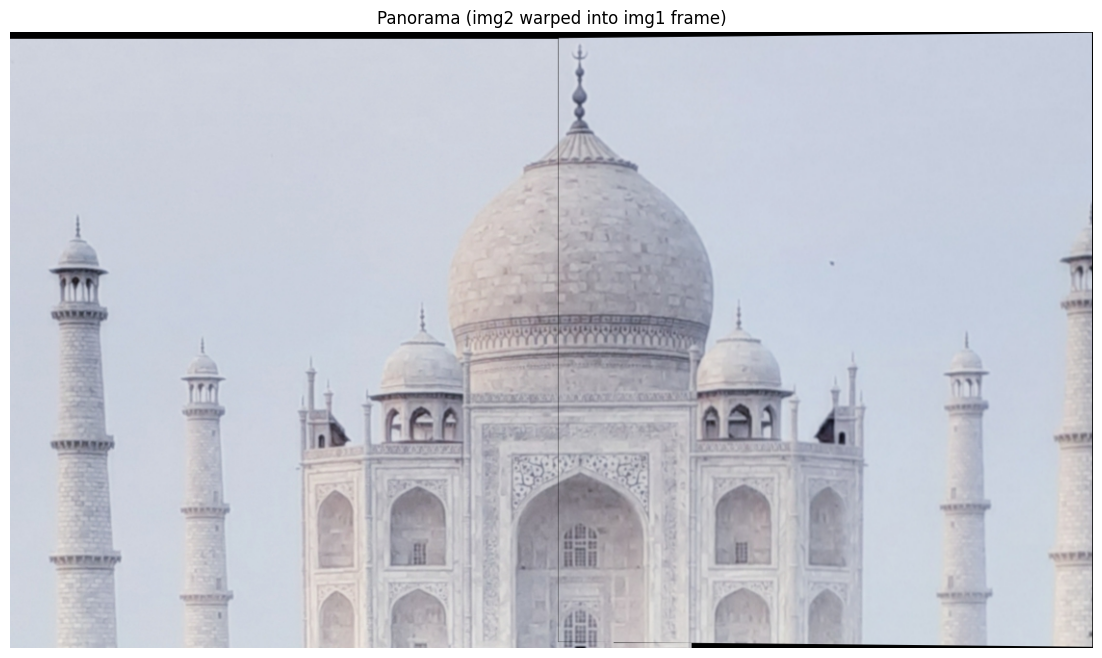

In [47]:
# *********************************************
# Step 6: Panorama stitching
# *********************************************

model, inliers = estimate_homography_ransac(coords1_nms, coords2_nms, matches, residual_threshold=3, max_trials=2000)

print("Inliers:", int(inliers.sum()), "/", len(inliers))
# maps img2 -> img1
H21 = model.params

base, img2_warp, (tx, ty) = make_panorama_canvas(img1[:, :, :3], img2[:, :, :3], H21)

pano = blend_average(base, img2_warp)
pano = crop_nonzero(pano)

# convert for display
pano_show = np.clip(pano, 0, 255).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.imshow(pano_show)
plt.axis("off")
plt.title("Panorama (img2 warped into img1 frame)")
save_current_plot(f"2_{filename}_panorama.png")
plt.show()